In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

KeyboardInterrupt: ignored

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
from sklearn import metrics
from copy import deepcopy
#from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
from time import perf_counter
import csv
import torch.nn as nn
import torch_geometric.nn as gnn
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
from torch.nn.modules import activation
from time import perf_counter
import random
import pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Explainability_name = 'Grad-CAM'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [ ]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [ ]:
#torch.manual_seed(123456)
#dataset = dataset.shuffle()

#train_dataset = dataset[:150]
#test_dataset = dataset[150:]
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
  read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
  read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

#print(f'Number of training graphs: {len(train_dataset)}')
#print(f'Number of test graphs: {len(test_dataset)}')

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [ ]:
train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
  train_dataset.append(dataset[index])
for index in read_test_list_indexes:
  test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


# **Batching Data by DataLoader**

In [ ]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64
size_of_hidden_layers = 7

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Model Designing**

In [ ]:
#class GCN(torch.nn.Module):
#    def __init__(self, hidden_channels):
#        super(GCN, self).__init__()
#        torch.manual_seed(12345)
#        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
#        self.conv2 = GCNConv(hidden_channels, hidden_channels)
#        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
#        self.lin = Linear(hidden_channels, dataset.num_classes)
#
#    def forward(self, x, edge_index, batch):
#        # 1. Obtain node embeddings 
#        x = self.conv1(x, edge_index)
#        x = torch.nn.functional.elu(x)
#
#        x = self.conv2(x, edge_index)
#        x_last_Conv = torch.nn.functional.elu(x)
#
#        #x = self.conv3(x, edge_index)
#        #x = torch.nn.functional.elu(x)
#
#        # 2. Readout layer
#        x_GAP = global_mean_pool(x_last_Conv, batch)  # [batch_size, hidden_channels]
#
#        # 3. Apply a final classifier
#        #x_GAP = F.dropout(x_GAP, p=0.5, training=self.training)
#        x_final = self.lin(x_GAP)
#        x_Final = F.softmax(x_final, dim=1)
#        
#        return x_last_Conv, x_Final
#
#
#Grad_CAM_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
#print(Grad_CAM_model_GCN)

In [ ]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [ ]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [ ]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [ ]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [ ]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            if self._explain:
                edge_mask = self.__edge_mask__
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [ ]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden, bias=False)
        #self.elu1 = nn.functional.elu() 
        
        self.gconv2 = GCNConv(dim_hidden, dim_hidden, bias=False)
        #self.elu2 = nn.functional.elu()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output, bias=False)

        self.dropout = nn.Dropout()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = nn.functional.elu(self.gconv1(x, edge_index))
        #out_readout1 = self.readout(post_conv1, batch)
        #print(np.shape(out_readout1))
        post_conv2 = nn.functional.elu(self.gconv2(post_conv1, edge_index))
        out_readout = self.readout(post_conv2, batch)

        #print(np.shape(out_readout))
        out = self.ffn(out_readout)

        return post_conv1, post_conv2, out_readout, out

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(post_conv1, edge_index))
            
        return post_conv2

In [ ]:
feat_size = train_dataset[0].x.shape[1]

Grad_CAM_model_GCN = GCN_2l_Model(model_level='graph', dim_node=feat_size, dim_hidden=feat_size, dim_output=dataset.num_classes)
Grad_CAM_model_GCN.eval()

GCN_2l_Model(
  (gconv1): GCNConv(7, 7)
  (gconv2): GCNConv(7, 7)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
Grad_CAM_optimizer = torch.optim.Adam(Grad_CAM_model_GCN.parameters(), lr=0.001)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch

In [ ]:
def loading_model(load_index):
  Grad_CAM_model_GCN = GCN_2l_Model(hidden_channels=size_of_hidden_layers)
  Grad_CAM_optimizer = torch.optim.Adam(params = Grad_CAM_model_GCN.parameters(), lr=0.001)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + str(Explainability_name) + " on " + str(Task_name) + " classifier model_" + str(epoch + load_index + 1)+".pt")
  Grad_CAM_model_GCN.load_state_dict(checkpoint['model_state_dict'])
  Grad_CAM_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return Grad_CAM_model_GCN, Grad_CAM_optimizer, epoch

In [ ]:
def visualize_losses(grad_cam_losses, epoch_history):
  grad_cam_losses_list = torch.stack(grad_cam_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("CAM Model Loss in Epoch: " + str(epoch_history))

  ax.plot(grad_cam_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  




# **Traning Configurations**

In [ ]:
def train_step():
  Grad_CAM_loss_batch = []
  Grad_CAM_Pred_Labels = []
  Real_Labels = []

  Grad_CAM_model_GCN.train()
  Grad_CAM_optimizer.zero_grad()
  for batched_data in train_loader:
    Grad_CAM_Training_One_Before_Last_Conv, Grad_CAM_Training_Last_Conv, Grad_CAM_Training_GAP, Grad_CAM_out = Grad_CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    pred = Grad_CAM_out.argmax(dim=1)
    Grad_CAM_Pred_Labels.extend(pred.detach().tolist())

    Real_Labels.extend(batched_data.y.detach().tolist())
    Grad_CAM_loss = loss_calculations(Grad_CAM_out, batched_data.y)
    Grad_CAM_loss_batch.append(Grad_CAM_loss)
    Grad_CAM_loss.backward()
    Grad_CAM_optimizer.step()

  Grad_CAM_optimizer.step()

  return torch.mean(torch.tensor(Grad_CAM_loss_batch)), metrics.accuracy_score(Real_Labels, Grad_CAM_Pred_Labels)


In [ ]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [ ]:
Grad_CAM_Model_training_time_per_epoch = []
Grad_CAM_Model_training_Acc_per_epoch = []
def train(EPOCHS, load_index):
  Grad_CAM_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    start_generation = perf_counter()
    Grad_CAM_model_training_loss, training_acc = train_step()
    Grad_CAM_Model_training_time_per_epoch.append(perf_counter() - start_generation)
    Grad_CAM_Model_training_Acc_per_epoch.append(training_acc)
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {Grad_CAM_model_training_loss:.4f}')

    Grad_CAM_training_loss_per_epoch.append(Grad_CAM_model_training_loss)
    #break

    if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(Grad_CAM_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': Grad_CAM_model_GCN.state_dict(), 'optimizer_state_dict': Grad_CAM_optimizer.state_dict(), 'loss': Grad_CAM_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + str(Explainability_name) + " on " + str(Task_name) + " classifier model_" + str(epoch + load_index + 1) + ".pt")

  
  #return model_loss





<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-28-d17a5d269471>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if load_index is not 0:


Epoch: 001, Grad-CAM Model Loss: 0.7023
Epoch: 002, Grad-CAM Model Loss: 0.6994
Epoch: 003, Grad-CAM Model Loss: 0.6951
Epoch: 004, Grad-CAM Model Loss: 0.6921
Epoch: 005, Grad-CAM Model Loss: 0.6886
Epoch: 006, Grad-CAM Model Loss: 0.6834
Epoch: 007, Grad-CAM Model Loss: 0.6843
Epoch: 008, Grad-CAM Model Loss: 0.6785
Epoch: 009, Grad-CAM Model Loss: 0.6681
Epoch: 010, Grad-CAM Model Loss: 0.6723
Epoch: 011, Grad-CAM Model Loss: 0.6646
Epoch: 012, Grad-CAM Model Loss: 0.6688
Epoch: 013, Grad-CAM Model Loss: 0.6659
Epoch: 014, Grad-CAM Model Loss: 0.6506
Epoch: 015, Grad-CAM Model Loss: 0.6590
Epoch: 016, Grad-CAM Model Loss: 0.6594
Epoch: 017, Grad-CAM Model Loss: 0.6505
Epoch: 018, Grad-CAM Model Loss: 0.6416
Epoch: 019, Grad-CAM Model Loss: 0.6420
Epoch: 020, Grad-CAM Model Loss: 0.6321
Epoch: 021, Grad-CAM Model Loss: 0.6514
Epoch: 022, Grad-CAM Model Loss: 0.6416
Epoch: 023, Grad-CAM Model Loss: 0.6484
Epoch: 024, Grad-CAM Model Loss: 0.6293
Epoch: 025, Grad-CAM Model Loss: 0.6309


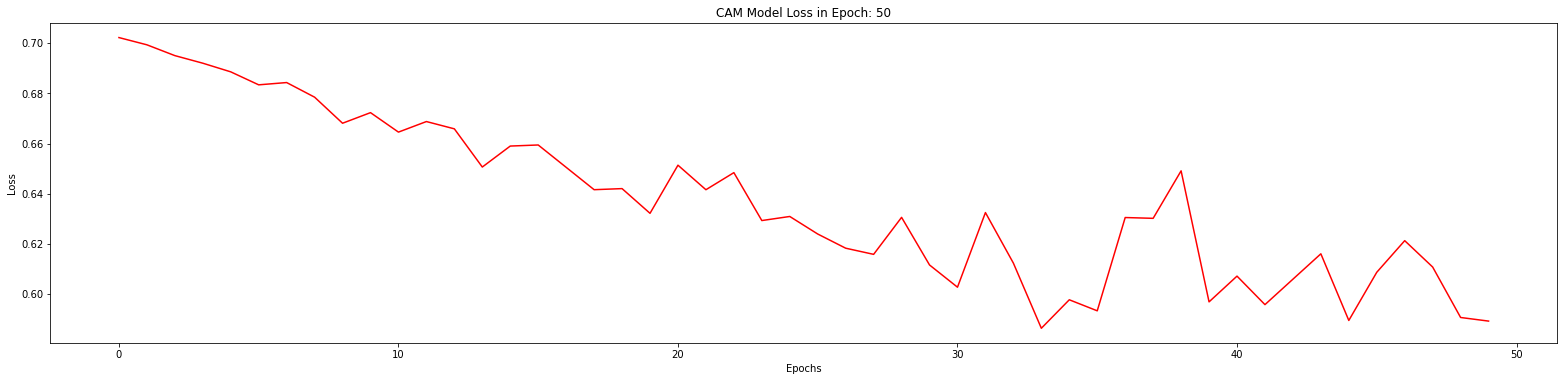

Epoch: 051, Grad-CAM Model Loss: 0.6109
Epoch: 052, Grad-CAM Model Loss: 0.5959
Epoch: 053, Grad-CAM Model Loss: 0.6048
Epoch: 054, Grad-CAM Model Loss: 0.5978
Epoch: 055, Grad-CAM Model Loss: 0.6037
Epoch: 056, Grad-CAM Model Loss: 0.5978
Epoch: 057, Grad-CAM Model Loss: 0.6185
Epoch: 058, Grad-CAM Model Loss: 0.5997
Epoch: 059, Grad-CAM Model Loss: 0.6090
Epoch: 060, Grad-CAM Model Loss: 0.6019
Epoch: 061, Grad-CAM Model Loss: 0.6095
Epoch: 062, Grad-CAM Model Loss: 0.6039
Epoch: 063, Grad-CAM Model Loss: 0.5898
Epoch: 064, Grad-CAM Model Loss: 0.5952
Epoch: 065, Grad-CAM Model Loss: 0.5728
Epoch: 066, Grad-CAM Model Loss: 0.6080
Epoch: 067, Grad-CAM Model Loss: 0.5669
Epoch: 068, Grad-CAM Model Loss: 0.5939
Epoch: 069, Grad-CAM Model Loss: 0.5934
Epoch: 070, Grad-CAM Model Loss: 0.5986
Epoch: 071, Grad-CAM Model Loss: 0.5770
Epoch: 072, Grad-CAM Model Loss: 0.5883
Epoch: 073, Grad-CAM Model Loss: 0.5717
Epoch: 074, Grad-CAM Model Loss: 0.5878
Epoch: 075, Grad-CAM Model Loss: 0.5811


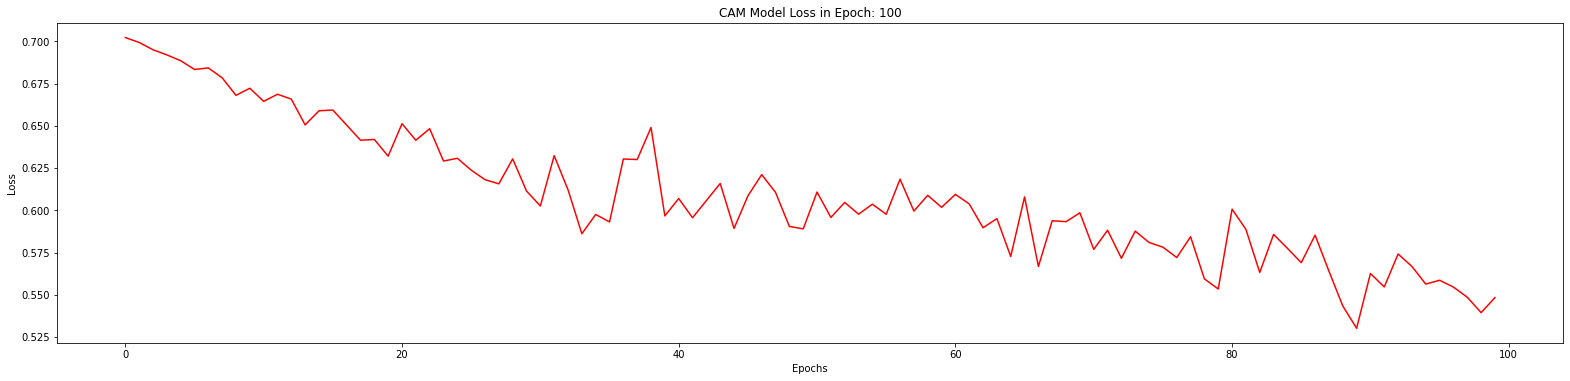

Epoch: 101, Grad-CAM Model Loss: 0.5569
Epoch: 102, Grad-CAM Model Loss: 0.5595
Epoch: 103, Grad-CAM Model Loss: 0.5372
Epoch: 104, Grad-CAM Model Loss: 0.5356
Epoch: 105, Grad-CAM Model Loss: 0.5609
Epoch: 106, Grad-CAM Model Loss: 0.5384
Epoch: 107, Grad-CAM Model Loss: 0.5334
Epoch: 108, Grad-CAM Model Loss: 0.5444
Epoch: 109, Grad-CAM Model Loss: 0.5066
Epoch: 110, Grad-CAM Model Loss: 0.5798
Epoch: 111, Grad-CAM Model Loss: 0.5544
Epoch: 112, Grad-CAM Model Loss: 0.5110
Epoch: 113, Grad-CAM Model Loss: 0.5188
Epoch: 114, Grad-CAM Model Loss: 0.5037
Epoch: 115, Grad-CAM Model Loss: 0.5267
Epoch: 116, Grad-CAM Model Loss: 0.5190
Epoch: 117, Grad-CAM Model Loss: 0.5065
Epoch: 118, Grad-CAM Model Loss: 0.5599
Epoch: 119, Grad-CAM Model Loss: 0.5582
Epoch: 120, Grad-CAM Model Loss: 0.5011
Epoch: 121, Grad-CAM Model Loss: 0.5370
Epoch: 122, Grad-CAM Model Loss: 0.5128
Epoch: 123, Grad-CAM Model Loss: 0.5138
Epoch: 124, Grad-CAM Model Loss: 0.5310
Epoch: 125, Grad-CAM Model Loss: 0.5217


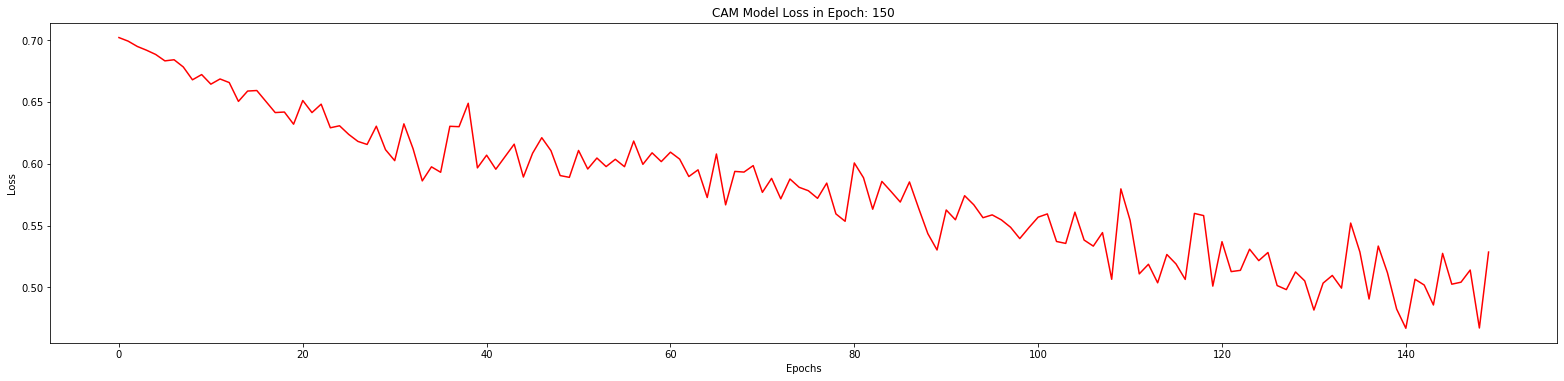

Epoch: 151, Grad-CAM Model Loss: 0.5191
Epoch: 152, Grad-CAM Model Loss: 0.5110
Epoch: 153, Grad-CAM Model Loss: 0.5030
Epoch: 154, Grad-CAM Model Loss: 0.4860
Epoch: 155, Grad-CAM Model Loss: 0.5246
Epoch: 156, Grad-CAM Model Loss: 0.4889
Epoch: 157, Grad-CAM Model Loss: 0.5158
Epoch: 158, Grad-CAM Model Loss: 0.4813
Epoch: 159, Grad-CAM Model Loss: 0.4847
Epoch: 160, Grad-CAM Model Loss: 0.5022
Epoch: 161, Grad-CAM Model Loss: 0.4912
Epoch: 162, Grad-CAM Model Loss: 0.5210
Epoch: 163, Grad-CAM Model Loss: 0.4865
Epoch: 164, Grad-CAM Model Loss: 0.5031
Epoch: 165, Grad-CAM Model Loss: 0.5216
Epoch: 166, Grad-CAM Model Loss: 0.4780
Epoch: 167, Grad-CAM Model Loss: 0.5044
Epoch: 168, Grad-CAM Model Loss: 0.4469
Epoch: 169, Grad-CAM Model Loss: 0.5072
Epoch: 170, Grad-CAM Model Loss: 0.5091
Epoch: 171, Grad-CAM Model Loss: 0.4828
Epoch: 172, Grad-CAM Model Loss: 0.5527
Epoch: 173, Grad-CAM Model Loss: 0.4883
Epoch: 174, Grad-CAM Model Loss: 0.5051
Epoch: 175, Grad-CAM Model Loss: 0.4946


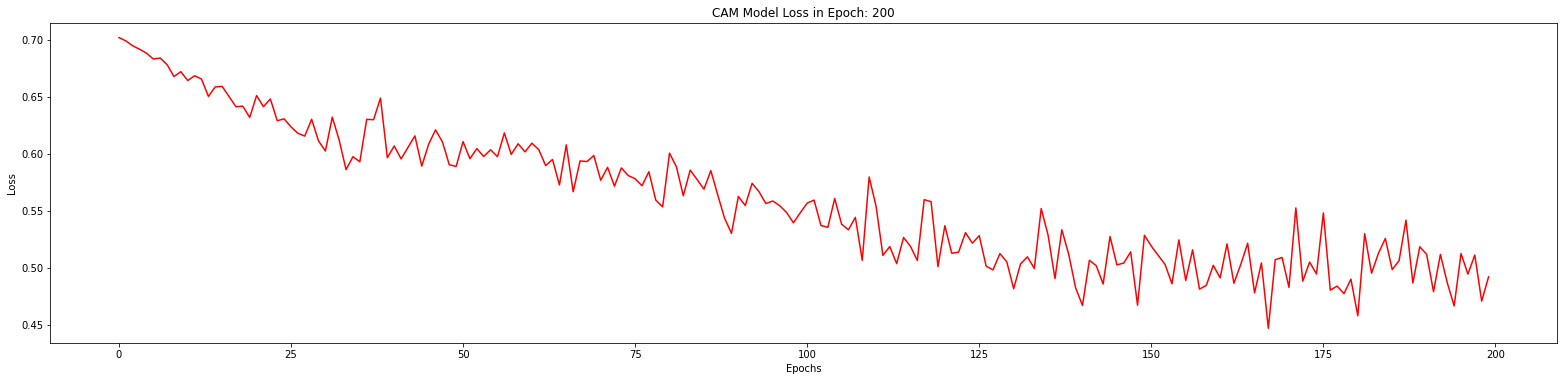

In [ ]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [ ]:
def Grad_CAM_test(test_loader):
  predictions = []
  Grad_CAM_model_GCN.eval()
  correct = 0
  for batched_data in test_loader:  
    Grad_CAM_Test_One_Before_Last_Conv, Grad_CAM_Test_Last_Conv, Grad_CAM_Test_GAP, Grad_CAM_Test_out = Grad_CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)  
    Grad_CAM_test_pred = Grad_CAM_Test_out.argmax(dim=1) 
    predictions.append(Grad_CAM_test_pred)  
    #print(Grad_CAM_test_pred) 
    correct += int((Grad_CAM_test_pred == batched_data.y).sum())  
  return correct / len(test_loader.dataset), predictions[0].detach().tolist()  

In [ ]:
Grad_CAM_test_acc, predictions = Grad_CAM_test(test_loader)
print(f'Test Accuracy: {Grad_CAM_test_acc:.4f}')

Test Accuracy: 0.5789


In [ ]:
print(predictions)
real_labels = []
for graph in test_dataset:
  real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [ ]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print(Auc_Roc, Auc_Prc, Acc, Acc2)

0.5327380952380952 0.7731950067476383 0.5789473684210527 22


## **Instance Specific Time**

In [ ]:
def instance_time(test_dataset):
  instance_based_time = []
  Grad_CAM_model_GCN.eval()
  correct = 0
  for batched_data in test_dataset:
    start_generation = perf_counter()
    post_conv1, post_conv2, out_readout, Grad_CAM_test_out = Grad_CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)  
    CAM_test_pred = Grad_CAM_test_out.argmax(dim=1)
    consumed_time = perf_counter() - start_generation
    instance_based_time.append(consumed_time)    
  return instance_based_time

In [ ]:
times = instance_time(test_dataset)
print(f'Test Instance based Time: {times}')

Test Instance based Time: [0.0037092899999606743, 0.00203925400001026, 0.001851273000056608, 0.0031169750000117347, 0.002650177000077747, 0.002181397999947876, 0.0014905329999237438, 0.002063349999843922, 0.0017657539999618166, 0.0012659340000027441, 0.0011861109999244945, 0.0017718700000841636, 0.0014162209999994957, 0.0010954899998978362, 0.0012934339999901567, 0.001135623999971358, 0.001027131000000736, 0.0010243870001431787, 0.001001092000024073, 0.0010375399999702495, 0.0010145629998987715, 0.0009702090001155739, 0.0010094470001149602, 0.0015965580000738555, 0.001064628999984052, 0.0010355819999858795, 0.001038390000076106, 0.0009925730000759359, 0.0013677580000148737, 0.0012888280000424857, 0.0010946899999453308, 0.0010221929999261192, 0.0012665579999975307, 0.001120396000032997, 0.0010313079999377806, 0.000997737000034249, 0.000996914000097604, 0.0011682409999593801]


In [ ]:
print(Grad_CAM_model_GCN.conv1)
StateDict = Grad_CAM_model_GCN.state_dict() # STATE DICT is for Weights and Biases
print(StateDict.keys())
whole_weights = StateDict.items()
#print(whole_weights)


Conv1_biases = StateDict.get('conv1.bias')
Conv1_Weights = StateDict.get('conv1.lin.weight')

Conv2_biases = StateDict.get('conv2.bias')
Conv2_Weights = StateDict.get('conv2.lin.weight')

Conv3_biases = StateDict.get('conv3.bias')
Conv3_Weights = StateDict.get('conv3.lin.weight')

Dense_biases = StateDict.get('lin.bias')
Dense_Weights = StateDict.get('lin.weight')

print(f'Length of CONV1_Weights: {len(Conv1_Weights)}')
print(f'Length of CONV1.Bias: {len(Conv1_biases)}')

print(f'Length of CONV2_Weights: {len(Conv2_Weights)}')
print(f'Length of CONV2.Bias: {len(Conv2_biases)}')

print(f'Length of CONV3_Weights: {len(Conv3_Weights)}')
print(f'Length of CONV3.Bias: {len(Conv3_biases)}')

print(f'Length of Dense_Weights: {len(Dense_Weights)}')
print(f'Length of Dense.Bias: {len(Dense_biases)}')


GCNConv(7, 7)
odict_keys(['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight', 'conv3.bias', 'conv3.lin.weight', 'lin.weight', 'lin.bias'])
Length of CONV1_Weights: 7
Length of CONV1.Bias: 7
Length of CONV2_Weights: 7
Length of CONV2.Bias: 7
Length of CONV3_Weights: 7
Length of CONV3.Bias: 7
Length of Dense_Weights: 2
Length of Dense.Bias: 2


In [ ]:
print(Dense_Weights)

tensor([[-0.6171, -1.2386, -1.1665,  0.0028,  0.5823, -0.3089,  0.2240],
        [ 1.1214,  1.2313,  1.1566,  0.1151, -0.6268, -0.0025,  0.4217]])


# **Gradients of the Last Conv Layer**

In [ ]:
def accumulate_gradients(model_for_you):
  gradients_of_the_Third_Conv_Bias = []
  gradients_of_the_Third_Conv_Weight = []
  
  for name, param in model_for_you.named_parameters():

    if name == "conv1.bias":
      gradients_of_the_First_Conv_Bias = param.grad.detach().clone()

    if name == "conv1.lin.weight":
      gradients_of_the_First_Conv_Weight = param.grad.detach().clone()

    if name == "conv2.bias":
      gradients_of_the_Second_Conv_Bias = param.grad.detach().clone()

    if name == "conv2.lin.weight":
      gradients_of_the_Second_Conv_Weight = param.grad.detach().clone()

    if name == "conv3.bias":
      gradients_of_the_Third_Conv_Bias.append(param.grad.detach().clone())

    if name == "conv3.lin.weight":
      gradients_of_the_Third_Conv_Weight.append(param.grad.detach().clone())

    if name == "lin.bias":
      gradients_of_the_First_Dense_Bias = param.grad.detach().clone()

    if name == "lin.weight":
      gradients_of_the_First_Dense_Weight = param.grad.detach().clone()
  

  return gradients_of_the_Third_Conv_Weight

In [ ]:
Grads_of_the_Third_Conv_Layer = accumulate_gradients(Grad_CAM_model_GCN)

In [ ]:
print(Grads_of_the_Third_Conv_Layer)

[tensor([[-0.0121, -0.0051,  0.0000,  0.0000, -0.0127,  0.0000,  0.0000],
        [-0.0187, -0.0076,  0.0000,  0.0000, -0.0188,  0.0000,  0.0000],
        [-0.0176, -0.0071,  0.0000,  0.0000, -0.0177,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0116,  0.0032,  0.0000,  0.0000,  0.0069,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])]


In [ ]:
def compute_grad(model, graph, with_respect):
  Grad_CAM_Test_One_Before_Last_Conv, Grad_CAM_Test_Last_Conv, Grad_CAM_Test_GAP, Grad_CAM_Test_out = model(graph.x, graph.edge_index, graph.batch)
  #print(prediction)
  if with_respect == 1 :
    loss = loss_calculations(Grad_CAM_Test_out, graph.y)
    #print(loss)
    #print("done")
  elif with_respect == 2:
    loss = loss_calculations(Grad_CAM_Test_out, torch.tensor([0]))
    #print(loss)  
  elif with_respect == 3:
    loss = loss_calculations(Grad_CAM_Test_out, torch.tensor([1]))
    #print(loss)
  return torch.autograd.grad(loss, list(model.parameters()),allow_unused=True)

In [ ]:
def remove_nones(sample_grads):
  #print(type(sample_grads[0]))
  sample_grads2 = []
  for item in sample_grads:
    Each_Graph = []
    for item2 in item:
      if item2 != None:
        Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))
      else:
        Each_Graph.append(torch.tensor(0))
    sample_grads2.append(Each_Graph)
    #print("separate                         ")
        #item2 = torch.tensor([0])
  #print(np.shape(sample_grads[0]))
  #print(np.shape(sample_grads2[0]))
  return sample_grads2

In [ ]:
def compute_sample_grads(model, test_dataset, with_respect):

  sample_grads = [compute_grad(model, graph, with_respect) for graph in test_dataset]
  #print(np.shape(sample_grads[0]))
  #print(sample_grads[20])
  sample_grads = remove_nones(sample_grads)
  sample_grads = zip(*sample_grads)
  sample_grads = [torch.stack(shards) for shards in sample_grads]
  #sample_grads = [print(shards) for shards in sample_grads]
  return sample_grads

In [ ]:
def compute_grad_cam_gradients(your_model, dataset):
  per_sample_grads_wrt_graph_label = compute_sample_grads(your_model, dataset, 1)
  per_sample_grads_wrt_class_zero = compute_sample_grads(your_model, dataset, 2)
  per_sample_grads_wrt_class_one = compute_sample_grads(your_model, dataset, 3)
  
  #print(np.shape(per_sample_grads_wrt_graph_label[0]))
  #print(np.shape(per_sample_grads_wrt_graph_label[1]))
  #print(np.shape(per_sample_grads_wrt_graph_label[2]))
  #print(np.shape(per_sample_grads_wrt_graph_label[3]))
  #print(np.shape(per_sample_grads_wrt_graph_label[4]))
  #print(np.shape(per_sample_grads_wrt_graph_label[5]))
  #print(np.shape(per_sample_grads_wrt_graph_label[6]))
  #print(np.shape(per_sample_grads_wrt_graph_label[7]))

  grads_wrt_graph_label = per_sample_grads_wrt_graph_label[2].detach().tolist()

  grads_wrt_class_zero = per_sample_grads_wrt_class_zero[2].detach().tolist()

  grads_wrt_class_one = per_sample_grads_wrt_class_one[2].detach().tolist()




  return grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one

In [ ]:
grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one = compute_grad_cam_gradients(Grad_CAM_model_GCN, test_dataset)
print(np.shape(grads_wrt_graph_label), np.shape(grads_wrt_class_zero), np.shape(grads_wrt_class_one))

(38, 7, 7) (38, 7, 7) (38, 7, 7)


<ipython-input-39-6b36ca0c9073>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))


# **Feature MAPs**

In [ ]:
def Grad_CAM_FeatureMAP_production(test_loader):
  index_of_winner_labels = []
  FeatureMaps_of_the_Last_Conv = []
  output_of_the_GAP = []
  Final_predictions = []

  Grad_CAM_model_GCN.eval()
  for batched_data in test_loader:  
    Grad_CAM_Test_One_Before_Last_Conv, Grad_CAM_Test_Last_Conv, Grad_CAM_Test_GAP, Grad_CAM_Test_out = Grad_CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    #index_of_winner_label = CAM_output.argmax(dim=1) 
    logits = F.log_softmax(Grad_CAM_Test_out, dim=1)
    prob = F.softmax(logits, dim=1)
    index_of_winner_label = prob.argmax(dim=1) 

    index_of_winner_labels.append(index_of_winner_label.detach().tolist()) 
    Final_predictions.append(prob.detach().tolist())

    FeatureMaps_of_the_Last_Conv.append(Grad_CAM_Test_Last_Conv.detach().tolist())
  return FeatureMaps_of_the_Last_Conv, Final_predictions, index_of_winner_labels

In [ ]:
FeatureMaps_of_the_Last_Conv, Final_predictions, index_of_winner_labels = Grad_CAM_FeatureMAP_production(test_dataset)

# **Attribution of Gradients and Maps**

In [ ]:
def Grad_CAM_Attribution_Scores(grads, feat_maps):
  Grads_and_Maps_Multiplication_on_Nodes_of_each_graph = []
  Normalized_Attributions = []

  for i in range(len(feat_maps)):
    Each_Graph = []
    for j in range(len(feat_maps[i])):
      Each_Node = []
      for k in range(len(grads[i])):
        Each_Node.append(np.multiply(grads[i][k], feat_maps[i][j]))
      Each_Graph.append(sum(np.mean(Each_Node, 0)))
    Grads_and_Maps_Multiplication_on_Nodes_of_each_graph.append(Each_Graph)
  #print(np.shape(Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[0]))
  for i in range(len(feat_maps)):
    Each_Graph = []
    for j in range(len(feat_maps[i])):
      Each_Graph.append(Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j])
    norm = [(float(i))/(max(Each_Graph) + 1e-16) for i in Each_Graph] 
    Normalized_Attributions.append(norm)
  return Normalized_Attributions

In [ ]:
print(np.shape(grads_wrt_graph_label))
print(np.shape(FeatureMaps_of_the_Last_Conv[0]))

(38, 7, 7)
(17, 7)


In [ ]:
atts = Grad_CAM_Attribution_Scores(grads_wrt_graph_label, FeatureMaps_of_the_Last_Conv)
print(np.shape(atts[0]))

(17,)


## **Fidelity**

In [ ]:
def Compute_ROC_AUC(your_model, your_dataset):
  preds = []
  reals = []
  #print(len(your_dataset))
  num_classes = 2
  
  if num_classes > 2:
    print("Fidelity is only for Binaryclassification")
    return 0
    
  your_model.eval()
  for batched_data in your_dataset:
    Grad_CAM_Test_One_Before_Last_Conv, Grad_CAM_Test_Last_Conv, Grad_CAM_Test_GAP, Grad_CAM_Test_out = your_model(batched_data.x, batched_data.edge_index, batched_data.batch)
    logits = F.log_softmax(Grad_CAM_Test_out, dim=1)
    prob = F.softmax(logits, dim=1)
    
    preds.append(prob.cpu().detach())
    
  for i in range(len(your_dataset)):
    reals.append(your_dataset[i].y.cpu().detach().tolist())  
  preds = torch.cat(preds).cpu().numpy()
  preds = preds[:, 1]

  
  roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
  return roc_auc

In [ ]:
def is_salient(score, importance_range):
	start, end = importance_range
	if start <= score <= end:
		return True
	else:
		return False

In [ ]:
def drop_important_nodes(your_dataset, importance_range, grads, feat_maps):
  CAM_attribution_scores = Grad_CAM_Attribution_Scores(grads, feat_maps)
  occluded_GNNgraph_list = []
  
  for i in range(len(CAM_attribution_scores)):
    sample_graph = deepcopy(your_dataset[i])
    for j in range(len(sample_graph.x)):
      
      if is_salient((CAM_attribution_scores[i][j]), importance_range):
        #print("before: ", sample_graph.x[j])
        sample_graph.x[j][:] = 0
        #print(torch.zeros_like(sample_graph.x[j]))
        #print("manipulated: ",sample_graph.x[j])
    occluded_GNNgraph_list.append(sample_graph)
  return occluded_GNNgraph_list

In [ ]:
def Fidelity(your_model, your_dataset, grads, feat_maps, importance_range):

  auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
  new_graph_dataset = drop_important_nodes(your_dataset, importance_range, grads, feat_maps)
  auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

  return auc_roc_after_droping_important_nodes - auc_roc_before_droping_important_nodes

## **Contrastivity**

In [ ]:
def binarize_scores(grads, feat_maps, importance_range):
  CAM_attribution_scores = Grad_CAM_Attribution_Scores(grads, feat_maps)
  binarized_attribution_scores_list = []
  for scores in CAM_attribution_scores:
    binary_score = ''
    for score in scores:
      if is_salient(abs(float(score)), importance_range):
        binary_score += '1'
      else:
        binary_score += '0'
    binarized_attribution_scores_list.append(binary_score)
  return binarized_attribution_scores_list

In [ ]:
def compute_contrastivity(grads_class0, grads_class1, feat_maps, importance_range):
  binarized_salient_nodes_for_class0 = binarize_scores(grads_class0, feat_maps, importance_range)
  binarized_salient_nodes_for_class1 = binarize_scores(grads_class1, feat_maps, importance_range)

  result_list = []
	# Calculate hamming distance
  for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
    assert len(class_0) == len(class_1)
    d = hamming(class_0, class_1)
    result_list.append(d / len(class_0))
    
  return sum(result_list) / len(result_list)

## **Sparsity**

In [ ]:
def binarize_nodes(grads_class0, grads_class1, grads_preds, feat_maps, importance_range):
  CAM_attribution_scores_class0 = Grad_CAM_Attribution_Scores(grads_class0, feat_maps)
  CAM_attribution_scores_class1 = Grad_CAM_Attribution_Scores(grads_class1, feat_maps)
  CAM_attribution_scores_graph = Grad_CAM_Attribution_Scores(grads_preds, feat_maps)

  class_0_salient_nodes = []
  class_1_salient_nodes = []
  salient_nodes_preds = []
  
  for i in range(len(CAM_attribution_scores_class0)):
      class_0_graph = []
      for j in range(len(CAM_attribution_scores_class0[i])):
        if is_salient((CAM_attribution_scores_class0[i][j]), importance_range):
          class_0_graph.append(1)
        else:
          class_0_graph.append(0)
      class_0_salient_nodes.append(class_0_graph)

  for i in range(len(CAM_attribution_scores_class1)):
      class_1_graph = []
      for j in range(len(CAM_attribution_scores_class1[i])):
        if is_salient((CAM_attribution_scores_class1[i][j]), importance_range):
          class_1_graph.append(1)
        else:
          class_1_graph.append(0)
      class_1_salient_nodes.append(class_1_graph)

  for i in range(len(CAM_attribution_scores_graph)):
      class_graph = []
      for j in range(len(CAM_attribution_scores_graph[i])):
        if is_salient((CAM_attribution_scores_graph[i][j]), importance_range):
          class_graph.append(1)
        else:
          class_graph.append(0)
      salient_nodes_preds.append(class_graph)

  return salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes

In [ ]:
def count_important_nodes(salient_list):
  return sum(salient_list)

In [ ]:
def compute_sparsity(feat_maps, grads_preds, grads_class0, grads_class1, importance_range):
  salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(grads_class0, grads_class1, grads_preds, feat_maps, importance_range)
  #print(salient_nodes_graph)
  #print(class_0_salient_nodes)
  #print(class_1_salient_nodes)
  sparsity_list = []
  for i in range(len(salient_nodes_preds)):
    d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
    d = d / (len(salient_nodes_preds) * 2)
    sparsity_list.append(1 - d)
  return sum(sparsity_list) / len(sparsity_list)

## **Get Metrics**

In [ ]:
def go_to_evaluations(your_model, dataset, importance_range):
  FeatureMaps_of_the_Last_Conv, Final_predictions, index_of_winner_labels = Grad_CAM_FeatureMAP_production(dataset)
  
  start_generation = perf_counter()
  grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one = compute_grad_cam_gradients(your_model, dataset)
  CAM_Atts = Grad_CAM_Attribution_Scores(grads_wrt_graph_label, FeatureMaps_of_the_Last_Conv)
  time_consumption = perf_counter() - start_generation

  fid_grad_cam_label = Fidelity(your_model, dataset, grads_wrt_graph_label, FeatureMaps_of_the_Last_Conv, importance_range)

  contrastivity_with_grad_cam = compute_contrastivity(grads_wrt_class_zero, grads_wrt_class_one, FeatureMaps_of_the_Last_Conv, importance_range)

  sparsity_with_grad_cam = compute_sparsity(FeatureMaps_of_the_Last_Conv, grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one, importance_range)


  #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
  #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
  #  wr = csv.writer(outcsv, dialect='excel', delimiter=',')
  #  wr.writerow([str(Explainability_name), "MUTAG", fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption])
  task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
  with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods for SoftWare.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow([str(Explainability_name), task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, Grad_CAM_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption, mean(Grad_CAM_Model_training_time_per_epoch), times])


  #return fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption

In [ ]:
#fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption = go_to_evaluations(Grad_CAM_model_GCN, test_dataset, (0.5, 1))
go_to_evaluations(Grad_CAM_model_GCN, test_dataset, (0.5, 1))

<ipython-input-39-6b36ca0c9073>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))


In [ ]:
#print(fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption)

0.10461538461538455 0.04674149056824348 0.9155124653739612 0.30650361300013174


In [ ]:
FeatureMaps_of_the_Last_Conv = torch.stack(FeatureMaps_of_the_Last_Conv).cpu().detach().numpy()
Grads_of_the_Third_Conv_Layer = torch.stack(Grads_of_the_Third_Conv_Layer).cpu().detach().numpy()

Final_predictions = torch.stack(Final_predictions).cpu().detach().numpy()

#index_list = index_list.detach().numpy()
index_list = index_list.tolist()
FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv.tolist()
Grads_of_the_Third_Conv_Layer = Grads_of_the_Third_Conv_Layer.tolist()

In [ ]:
#print(FeatureMaps_of_the_Last_Conv)
#print(len(FeatureMaps_of_the_Last_Conv[0]))
print(np.shape(FeatureMaps_of_the_Last_Conv))
print(np.shape(Grads_of_the_Third_Conv_Layer))
print(np.shape(Final_predictions))
print(index_list)


(1, 706, 7)
(1, 7, 7)
(1, 38, 2)
[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


In [ ]:
FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv[0].copy()

# **Averaging Gradients**

In [ ]:
Grads_of_the_Third_Conv_Layer = Grads_of_the_Third_Conv_Layer[0].copy()

In [ ]:
print(Grads_of_the_Third_Conv_Layer[0])
print(Grads_of_the_Third_Conv_Layer[1])
print(Grads_of_the_Third_Conv_Layer[2])
print(Grads_of_the_Third_Conv_Layer[3])
print(Grads_of_the_Third_Conv_Layer[4])
print(Grads_of_the_Third_Conv_Layer[5])
print(Grads_of_the_Third_Conv_Layer[6])

[-0.012140744365751743, -0.005140058696269989, 0.0, 0.0, -0.012673529796302319, 0.0, 0.0]
[-0.01869245059788227, -0.007590681780129671, 0.0, 0.0, -0.018815919756889343, 0.0, 0.0]
[-0.017570869997143745, -0.007138625718653202, 0.0, 0.0, -0.017693085595965385, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.011570261791348457, 0.0031905954238027334, 0.0, 0.0, 0.006916387472301722, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
AVG_Grads_of_the_Third_Conv_Layer = np.mean(Grads_of_the_Third_Conv_Layer, axis=0)
print(AVG_Grads_of_the_Third_Conv_Layer)

[-0.00526197 -0.00238268  0.          0.         -0.00603802  0.
  0.        ]


In [ ]:
Feature_Maps_of_the_Last_Conv = []
for i in range(len(test_dataset)):
  Feature_Maps_of_the_Last_Conv.append(FeatureMaps_of_the_Last_Conv[0:test_dataset[i].num_nodes])
  FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv[test_dataset[i].num_nodes:]

In [ ]:
print(len(FeatureMaps_of_the_Last_Conv))
print(np.shape(Feature_Maps_of_the_Last_Conv[0]))
print(len(test_dataset))


#for i in range(len(test_dataset)):
#  print(test_dataset[i].num_nodes, len(Feature_Maps_of_the_Last_Conv[i]))

0
(28, 7)
38


# **Gradients and Maps multiplications**

In [ ]:
#print(len(Feature_Maps_of_the_Last_Conv))
AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph = []
for i in range(len(Feature_Maps_of_the_Last_Conv)):
  Each_Graph = []
  for j in range(len(Feature_Maps_of_the_Last_Conv[i])):
    Each_Graph.append(np.multiply(AVG_Grads_of_the_Third_Conv_Layer, Feature_Maps_of_the_Last_Conv[i][j]))
  AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph.append(Each_Graph)

In [ ]:
print('Num of Graphs: ',len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph))
print(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[0]))

Num of Graphs:  38
28


# **Pointwise Average for each Graph**

In [ ]:
Grad_CAMs_AVG_for_each_Graph = []
for i in range(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph)):
  Grad_CAMs_AVG_for_each_Graph.append(np.mean(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[i], axis=0))   # MEAN or ARGMAX then divide by counts of nodes in each GRAPH
print(np.shape(Grad_CAMs_AVG_for_each_Graph))

(38, 7)


# **Point-Wise Sum for each Graph**

In [ ]:
Grad_CAMs_SUM_for_each_Graph = []
for i in range(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph)):
  sum = [0] * len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[0][0])
  for j in range(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[i])):
    sum = list( map(add, sum, AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j]))
  Grad_CAMs_SUM_for_each_Graph.append(sum)

In [ ]:
print(np.shape(Grad_CAMs_SUM_for_each_Graph))
print(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[0]))
print(Grad_CAMs_AVG_for_each_Graph[0])
print(Grad_CAMs_SUM_for_each_Graph[0])

(38, 7)
28
[-0.00639422 -0.00472896  0.          0.         -0.0158634   0.
  0.        ]
[-0.17903812079860298, -0.1324109559838339, 0.0, 0.0, -0.44417515013710723, 0.0, 0.0]


# **Plot Attributes of Each Graph (i.e., in SUM of its Nodes)**

In [ ]:
def visualize_Grad_CAMs(Grad_CAMs_Graphs, index, HIV_status):

  fig = plt.figure(figsize=(15,10))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Attributes')
  plt.ylabel('Grad-CAMs; Gradients & Feature Maps')
  plt.title("Grad-CAMs in Test Graph: " + str(index+1) + " whith " + str(HIV_status) + "status")

  ax.plot(Grad_CAMs_Graphs, color='r')

  plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Grad-CAMs in Test Graph {:04d} with {} status.png'.format(index+1, HIV_status))
  plt.show() 

In [ ]:
HIV_POS = []
HIV_NEG = []

HIV_POS_index = []
HIV_NEG_index = []

for i, x in enumerate(Grad_CAMs_SUM_for_each_Graph):
  if index_list[i]:
    HIV_POS.append(x)
    HIV_POS_index.append(i)
  else:
    HIV_NEG.append(x)
    HIV_NEG_index.append(i)
print(len(HIV_POS))
print(len(HIV_NEG))

print(len(HIV_POS_index))
print(len(HIV_NEG_index))
print(index_list)
print(HIV_POS_index)
print(HIV_NEG_index)

27
11
27
11
[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
[0, 2, 3, 5, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 22, 23, 24, 27, 28, 29, 30, 32, 33, 34, 36, 37]
[1, 4, 6, 7, 13, 20, 21, 25, 26, 31, 35]


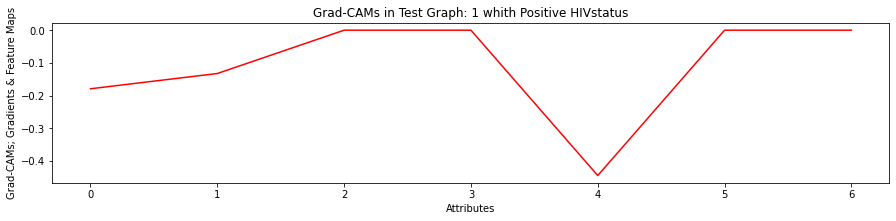

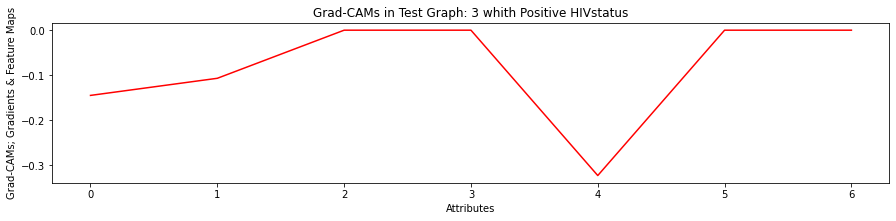

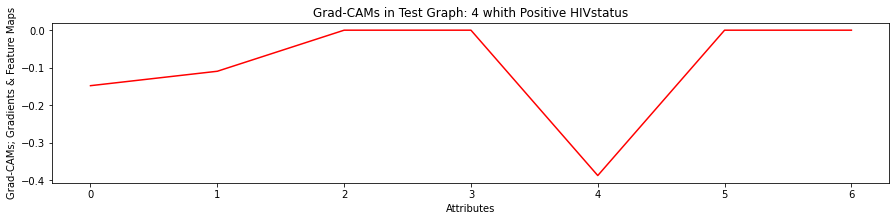

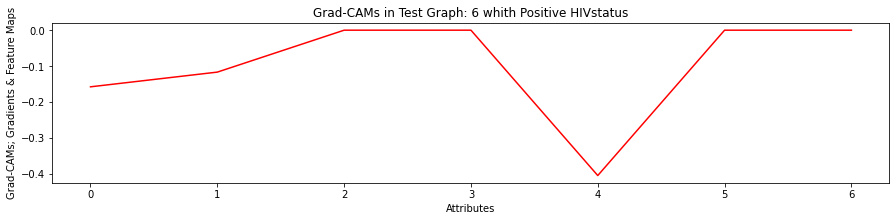

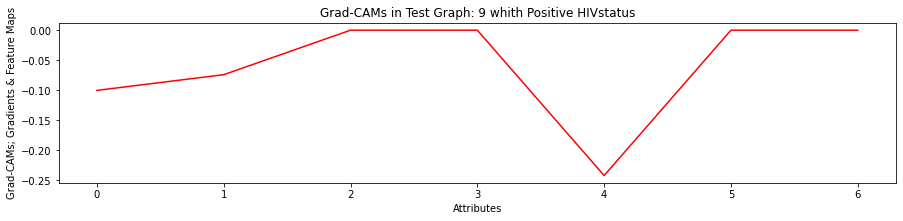

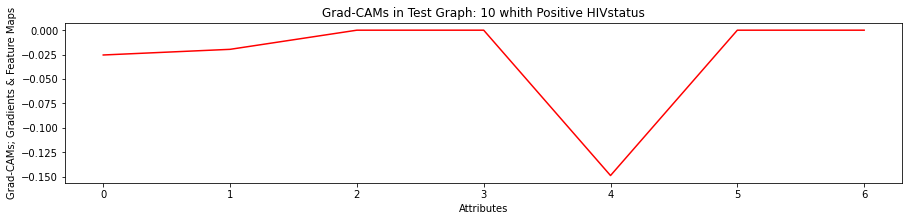

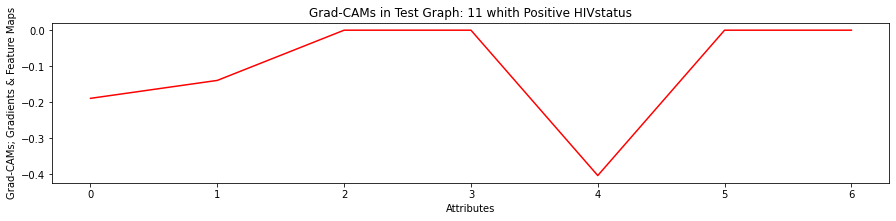

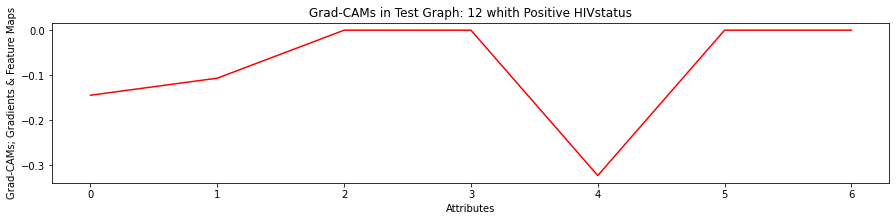

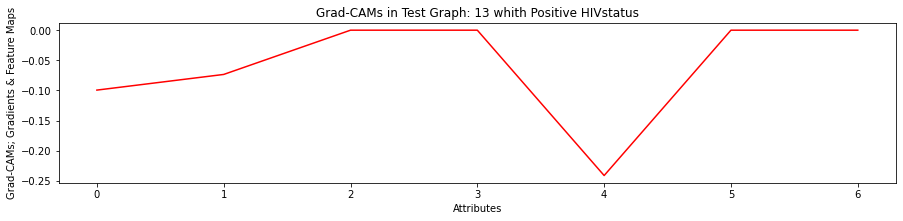

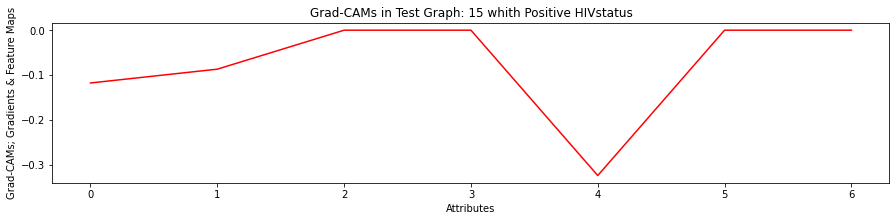

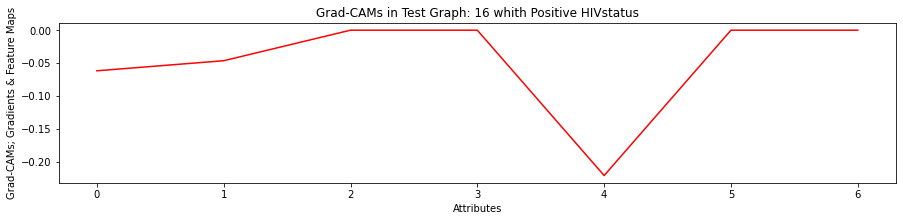

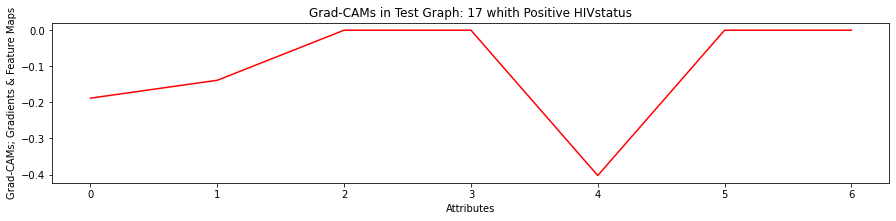

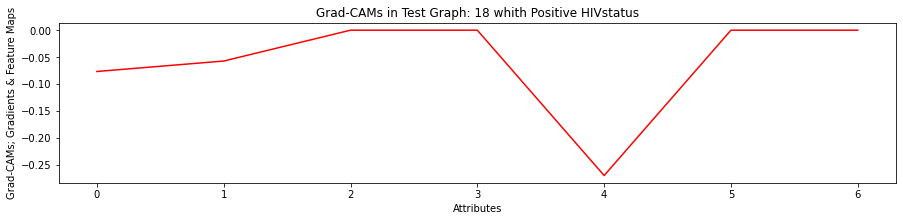

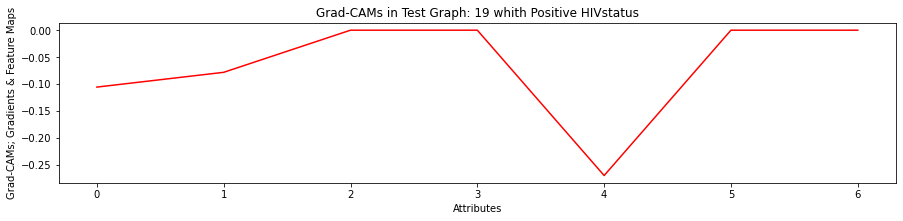

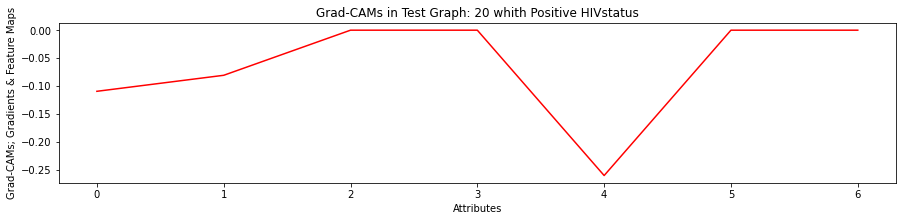

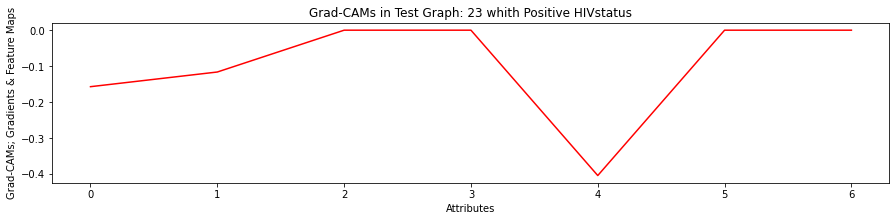

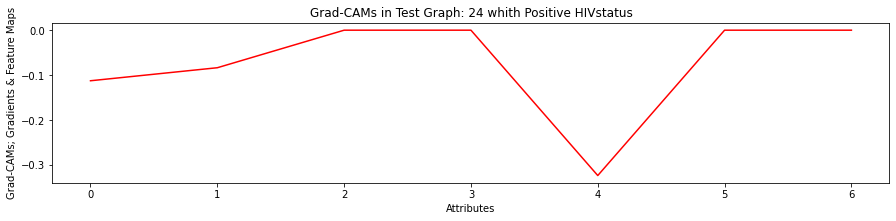

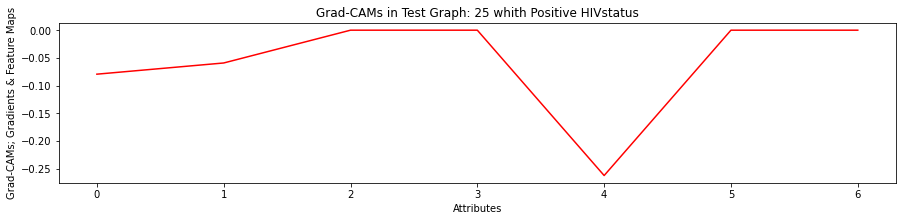

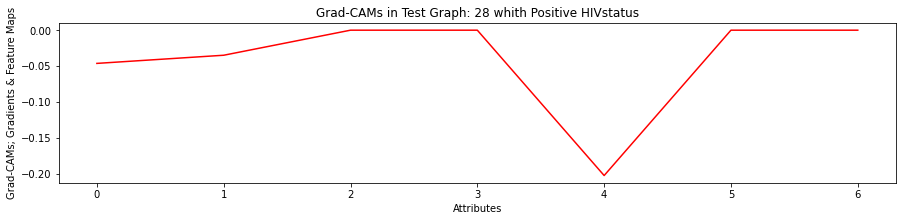

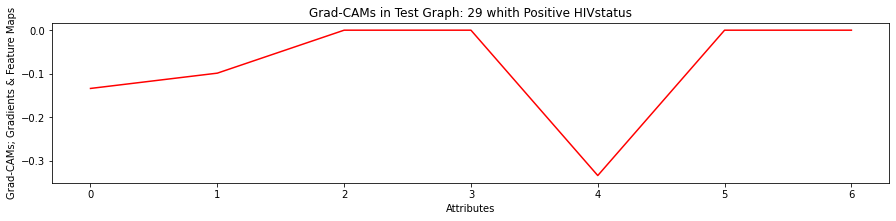

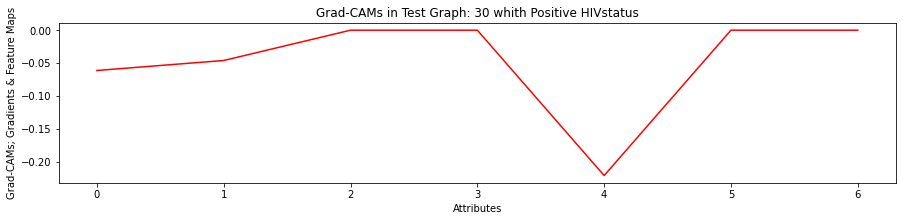

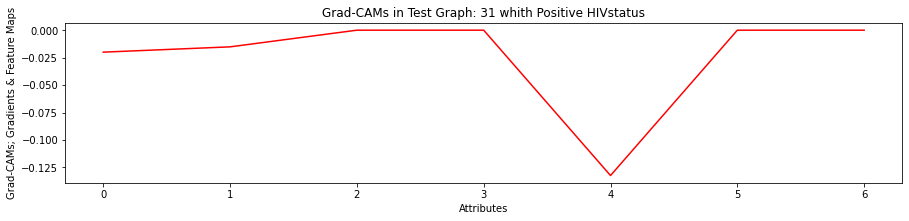

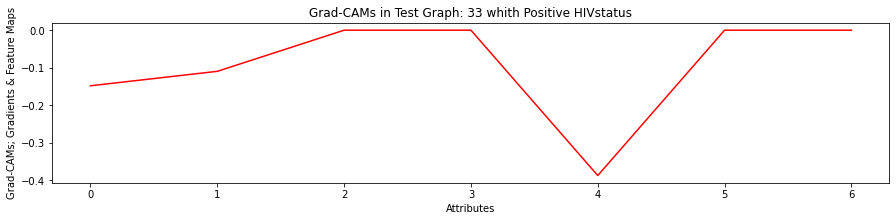

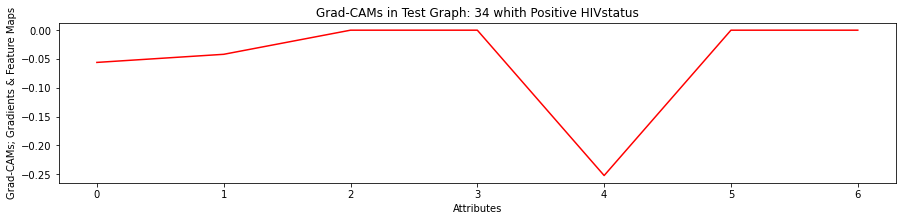

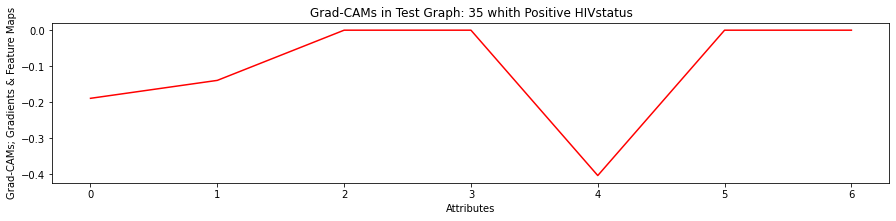

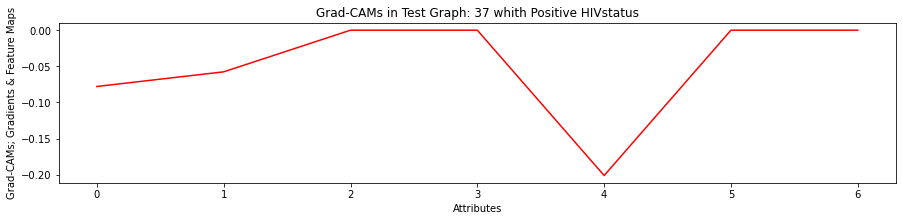

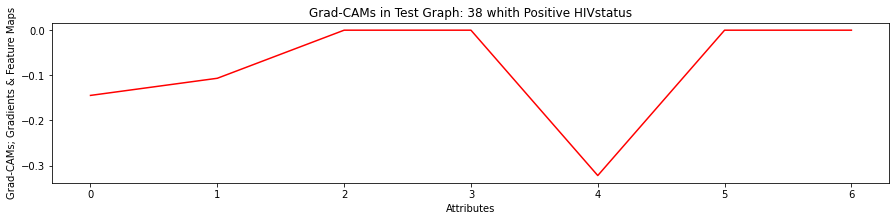

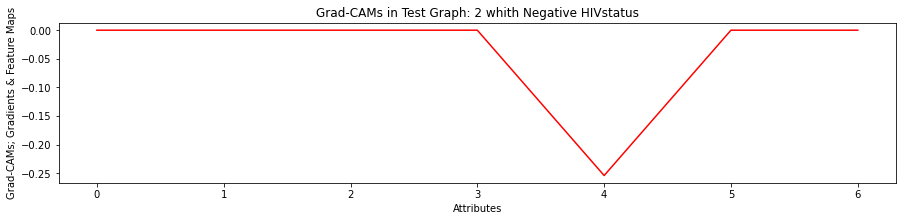

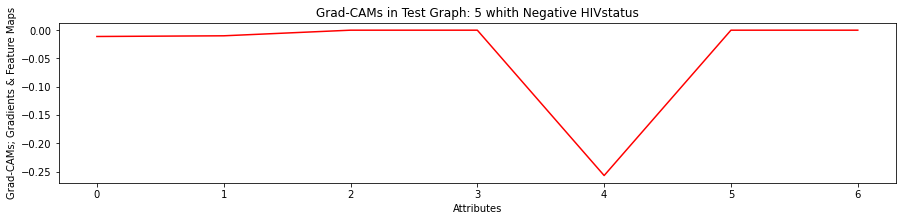

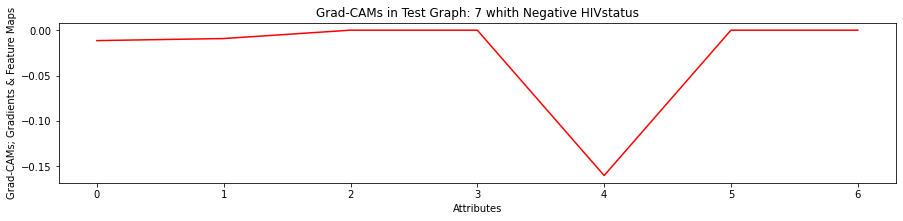

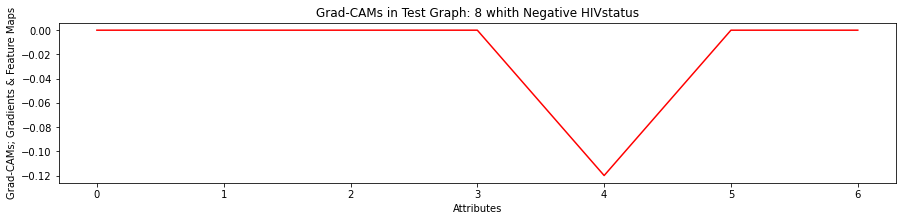

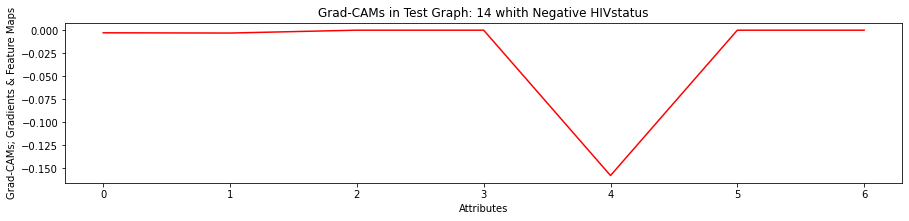

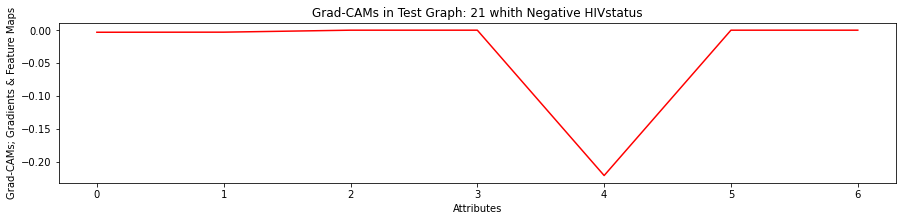

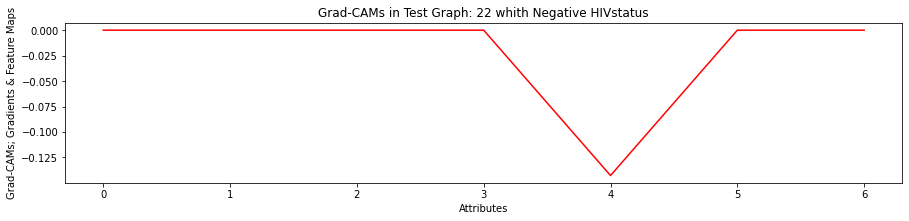

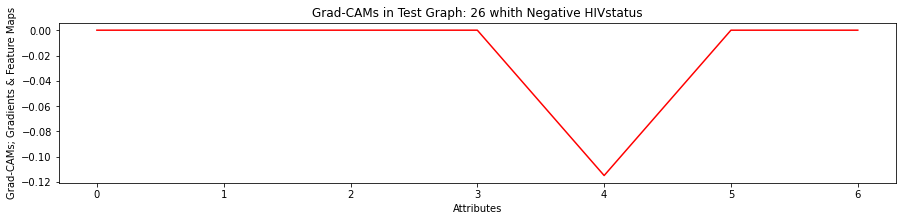

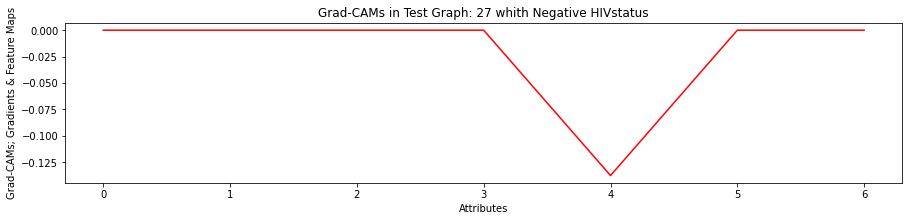

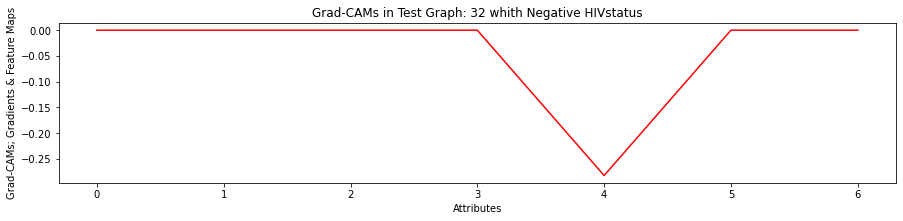

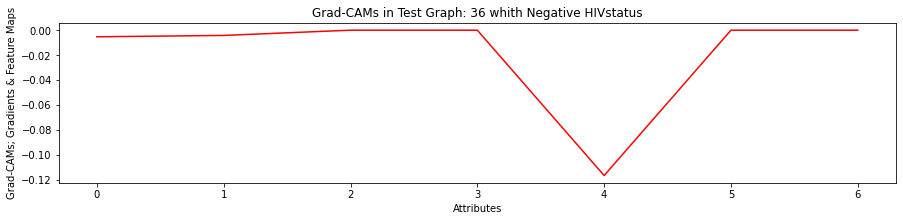

In [ ]:
HIV_status = "Positive HIV"
for i in range(len(HIV_POS)):
  visualize_Grad_CAMs(HIV_POS[i], HIV_POS_index[i], HIV_status)

HIV_status = "Negative HIV"
for i in range(len(HIV_NEG)):
  visualize_Grad_CAMs(HIV_NEG[i], HIV_NEG_index[i], HIV_status)

In [ ]:
#print(Weights_of_the_Winner_Node[0])
#print('***********************************')
#print(Feature_Maps_of_the_Last_Conv[0][0])
#print('===================================')
#print(CAMs_of_Nodes_for_each_graph[0][0])

In [ ]:
#print(np.shape(FeatureMaps_of_the_Last_Conv))
#for i in range(len(FeatureMaps_of_the_Last_Conv[0])):
#  print(FeatureMaps_of_the_Last_Conv[0][i])

In [ ]:
#CAM_model_GCN.eval()
#x = []
#for batched_data in test_dataset:  
#    Last_Conv, GAP, cam_preds = CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
#    x.append(Last_Conv)

In [ ]:
#print('CAM_Test_Last_Conv')
#print(CAM_Test_Last_Conv)
#print("=========================================================================")
#print(len(x))

#summ = 0
#for i in range(len(x)):
#  print(len(x[i]), test_dataset[i].num_nodes)
#  summ=summ+len(x[i])
#print(summ)

# **Upto the last Conv layer**

# **Gradients of CAM**


In [ ]:
'''def accumulate_gradients(model_for_you):
  before_CAM = []
  after_CAM = []
  
  for name, param in model_for_you.named_parameters():

    if name == "conv1.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv1.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "conv2.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv2.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "conv3.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv3.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "lin.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
  

  return before_CAM, after_CAM'''

In [ ]:
#holder_of_old_gradients, holder_of_new_gradients = accumulate_gradients(CAM_model_GCN)

In [ ]:
#print(len(holder_of_new_gradients))

8
